# 1. Import Libraries

In [18]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

# 2. Parameter

In [19]:
# declare path
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 125
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# 3. Prepare data

In [20]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [21]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# 4. Explore data

In [22]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))

,surprise,fear,angry,neutral,sad,disgust,happy
train,3171,4097,3995,4965,4830,436,7215
test,831,1024,958,1233,1247,111,1774


In [23]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [24]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


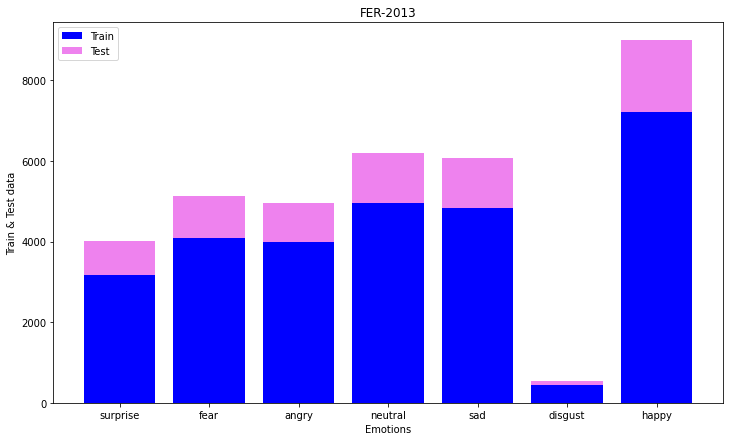

In [25]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

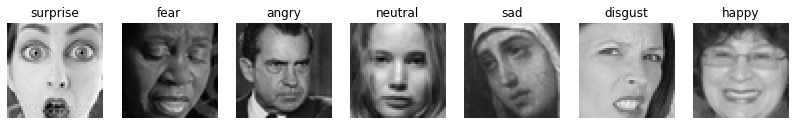

In [26]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

In [27]:
# Mobinet

base_model = tf.keras.applications.MobileNet(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 24, 24, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 24, 24, 32) 

In [28]:
# Freezing Layers

for layer in base_model.layers[:-9]:
    layer.trainable=False

In [29]:
print("Model trainable",len(base_model.layers))

Model trainable 86


In [30]:
print("Model trainable",len(base_model.trainable_variables))

Model trainable 9


In [31]:
# Model trainable

print("Model trainable",len(base_model.trainable_variables))

Model trainable 9


In [32]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1, 1, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [33]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [34]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)


Epoch 1/125
449/449 [==============================] - 67s 144ms/step - loss: 4.8662 - accuracy: 0.8244 - precision: 0.2203 - recall: 0.0902 - auc: 0.5713 - f1_score: 0.1278 - val_loss: 2.5110 - val_accuracy: 0.8500 - val_precision: 0.4125 - val_recall: 0.1172 - val_auc: 0.6608 - val_f1_score: 0.1813
Epoch 2/125
449/449 [==============================] - 61s 136ms/step - loss: 4.2694 - accuracy: 0.8390 - precision: 0.3168 - recall: 0.1097 - auc: 0.6283 - f1_score: 0.1625 - val_loss: 2.4053 - val_accuracy: 0.8544 - val_precision: 0.4732 - val_recall: 0.1684 - val_auc: 0.7088 - val_f1_score: 0.2463
Epoch 3/125
449/449 [==============================] - 63s 141ms/step - loss: 4.0543 - accuracy: 0.8436 - precision: 0.3531 - recall: 0.1140 - auc: 0.6530 - f1_score: 0.1718 - val_loss: 2.3398 - val_accuracy: 0.8572 - val_precision: 0.5002 - val_recall: 0.1640 - val_auc: 0.7216 - val_f1_score: 0.2436
Epoch 4/125
449/449 [==============================] - 62s 139ms/step - loss: 3.8736 - accurac

# 6. Evaluate Model

## 6.1 Check some Score 

In [35]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 7s 63ms/step - loss: 1.4721 - accuracy: 0.8808 - precision: 0.6210 - recall: 0.4248 - auc: 0.8593 - f1_score: 0.5016


In [36]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))




Model Scores



,Metric Name,Train,Validate
0,Loss,0.994,1.472
1,Accuracy,0.916,0.881
2,Precision,0.804,0.621
3,Recall,0.541,0.425
4,Auc,0.938,0.859
5,F1_Score,0.646,0.502


## 6.2 Visualize results

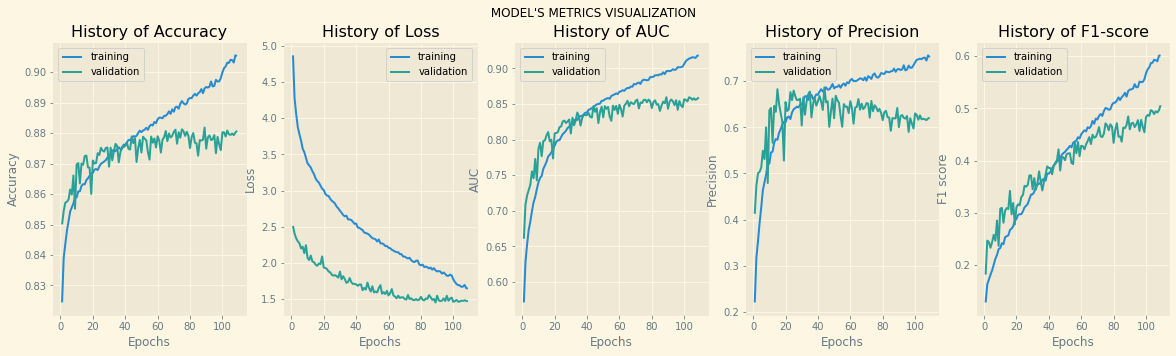

In [37]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

## 6.3 Confusion Matrix

In [38]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

Confusion matrix, without normalization

[[144  23 123 211 213 131 113]
 [ 17   0  12  28  30  13  11]
 [149  32 108 230 225 147 133]
 [233  31 207 385 447 249 222]
 [188  31 126 260 272 173 183]
 [196  30 133 263 264 179 182]
 [126  23 103 168 168 104 139]]





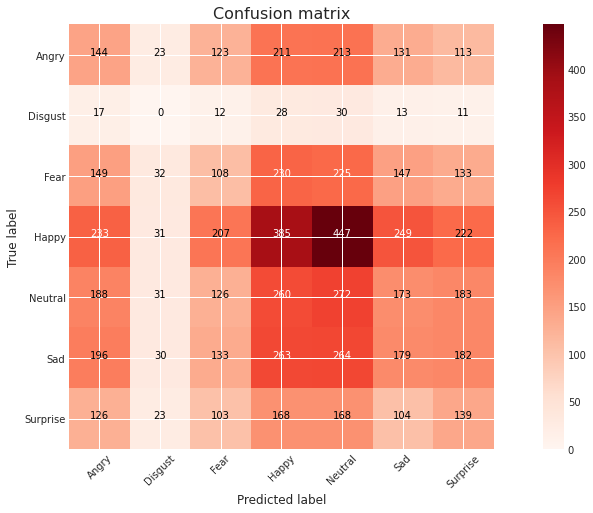

In [39]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

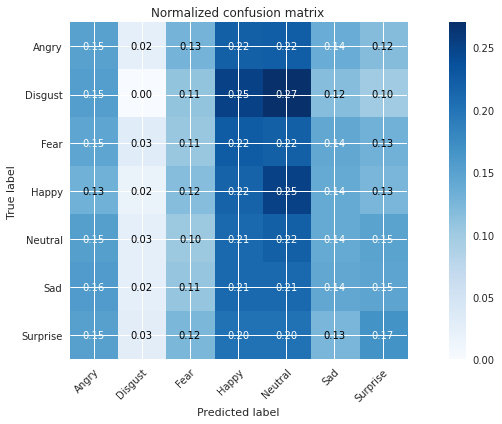

In [40]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


# 7. Save Model

In [41]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


(48, 48, 1)


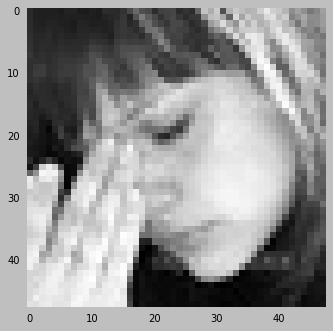

10702106

In [53]:
plt.style.use('grayscale')
plt.grid(visible=None)
img_path='../input/fer2013/test/sad/PrivateTest_10702106.jpg'
test_image=image.load_img(img_path,target_size= IMAGE_SIZE,color_mode='grayscale')
test_image=image.img_to_array(test_image)
print(test_image.shape)
plt.imshow(test_image)
plt.show()

10702106


# 8. Test/Predict

In [54]:
img=image.load_img(img_path,target_size=IMAGE_SIZE)
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [55]:
result=model.predict(img)
print(result[0])
y_pred=np.argmax(result[0])
print('The person facial emotion is:',classes[y_pred])

[2.1771491e-02 4.6892688e-05 1.9473286e-01 6.2871221e-03 1.2843494e-01
 6.0734838e-01 4.1378275e-02]
The person facial emotion is: Sad
